In [1]:
import os
from sqlalchemy import create_engine
from base import Base
from model import CoronaVirus
import pandas as pd

# get dabase uri
db_string = os.getenv('DB_URI')

# create database engine
engine = create_engine(db_string)


In [2]:
conn = engine.connect()
result = conn.execute("select * from coronavirus")
coronavirus = pd.DataFrame(result.fetchall())
coronavirus.columns = result.keys()
result = conn.execute("select * from countries")
countries = pd.DataFrame(result.fetchall())
countries.columns = ['country_id', 'country', 'code']
result = conn.execute("select * from dates")
dates = pd.DataFrame(result.fetchall())
dates.columns = ['date_id', 'date']

In [13]:
data = pd.merge(coronavirus, countries, how = 'outer', on = 'country_id')
data = pd.merge(data, dates, how = 'outer', on = 'date_id')
#data = data[data['country'] not in ['San Marino', 'Andorra', 'Liechtenstein', 'Monaco', 'Luxembourg'].index]
notWanted = data[(data['country'] == 'San Marino') | (data['country'] == 'Andorra') | (data['country'] == 'Liechtenstein')
                | (data['country'] == 'Monaco') | (data['country'] == 'Luxembourg')].index
data.drop(notWanted, inplace = True)
data.set_index('id', inplace = True)
data.drop(['date_id', 'country_id', 'deaths', 'recovered', 'code'], axis = 1, inplace = True)
data.to_csv('dataPre.csv')

In [14]:
population = pd.read_csv('WPP2019_TotalPopulationBySex.csv')
population = population.loc[population['Time'] == 2019]
population.drop(['LocID', 'VarID', 'Variant', 'Time', 'MidPeriod', 'PopMale', 'PopFemale', 'PopDensity'], axis = 1, inplace = True)
population.at[population['Location'] == 'Russian Federation', 'Location'] = 'Russia'
population.at[population['Location'] == 'United States of America', 'Location'] = 'United States'
population.at[population['Location'] == 'Venezuela (Bolivarian Republic of)', 'Location'] = 'Venezuela'
population.at[population['Location'] == 'Bolivia (Plurinational State of)', 'Location'] = 'Bolivia'
population.at[population['Location'] == 'Czechia', 'Location'] = 'Czech Republic'
data.at[data['country'] == 'US', 'country'] = 'United States'
data.at[data['country'] == 'Iran', 'country'] = 'Iran (Islamic Republic of)'
data.at[data['country'] == 'Czechia', 'country'] = 'Czech Republic'
#print(population['Location'].value_counts())
population.rename(columns = {'Location': 'country', 'PopTotal': 'population'}, inplace = True)
data = pd.merge(data, population, how = 'inner', on = 'country')
#data.drop(['population_x', 'population_y'], axis = 1, inplace = True)
data.head()

,confirmed,country,date,population
0,0.0,Afghanistan,2020-01-23,38041.757
1,0.0,Afghanistan,2020-01-24,38041.757
2,0.0,Afghanistan,2020-01-25,38041.757
3,0.0,Afghanistan,2020-01-26,38041.757
4,0.0,Afghanistan,2020-01-27,38041.757


In [15]:
data['casesPerMillion'] = data['confirmed'] / data['population'] * 1000
data.drop(['confirmed', 'population'], axis = 1, inplace = True)
data.head()

,country,date,casesPerMillion
0,Afghanistan,2020-01-23,0.0
1,Afghanistan,2020-01-24,0.0
2,Afghanistan,2020-01-25,0.0
3,Afghanistan,2020-01-26,0.0
4,Afghanistan,2020-01-27,0.0


In [16]:
dataPivoted = data.pivot(index = 'country', columns = 'date', values = 'casesPerMillion')
dataPivoted.head()
dataPivoted.to_csv('dataPivoted.csv')

In [1]:
import geopandas as gpd

In [2]:
#gpd.set_option('display.max_rows', 200)
world = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')
#world.loc[world['NAME'] == 'Congo (Democratic Republic of)']

In [3]:
world.drop(['FIPS', 'ISO2', 'ISO3', 'UN', 'AREA', 'POP2005', 'REGION', 'SUBREGION', 'LON', 'LAT'], axis = 1, inplace = True)
world.head()

,NAME,geometry
0,Antigua and Barbuda,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
1,Algeria,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ..."
2,Azerbaijan,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."
3,Albania,"POLYGON ((19.43621 41.02107, 19.45055 41.06000..."
4,Armenia,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40..."


In [13]:
import pandas as pd
dataPivoted = pd.read_csv('dataPivoted.csv')
world.columns = ['country', 'geometry']
# dataPivotedWithWorld = pd.merge(dataPivoted, world, how = 'inner', on = 'country')
# dataPivotedWithWorld.head()
dataPivotedWithWorld = world.merge(dataPivoted, how = 'inner', on = 'country')
#dataPivotedWithWorld.loc[dataPivotedWithWorld['country'] == 'Russia']
# dataPivoted.loc[dataPivoted['country'] == 'Russia']
dataPivotedWithWorld.head()

,country,geometry,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05
0,Antigua and Barbuda,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,247.129692,247.129692,247.129692,247.129692,247.129692,257.426762,257.426762,257.426762,257.426762,257.426762
1,Algeria,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.554241,81.689908,84.755892,89.378096,93.047987,96.485606,99.760635,103.918296,107.959821,112.372981
2,Azerbaijan,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,163.718750,167.003078,170.884556,175.761285,179.543238,184.519491,188.500494,192.282447,197.457751,205.021657
3,Albania,"POLYGON ((19.43621 41.02107, 19.45055 41.06000...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,252.003445,255.474567,260.334137,265.887932,268.317717,271.441727,273.871512,275.954185,278.731083,284.631990
4,Armenia,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,590.317974,611.280010,631.227753,653.204081,698.509126,726.233109,768.495277,806.700278,847.610057,885.476961


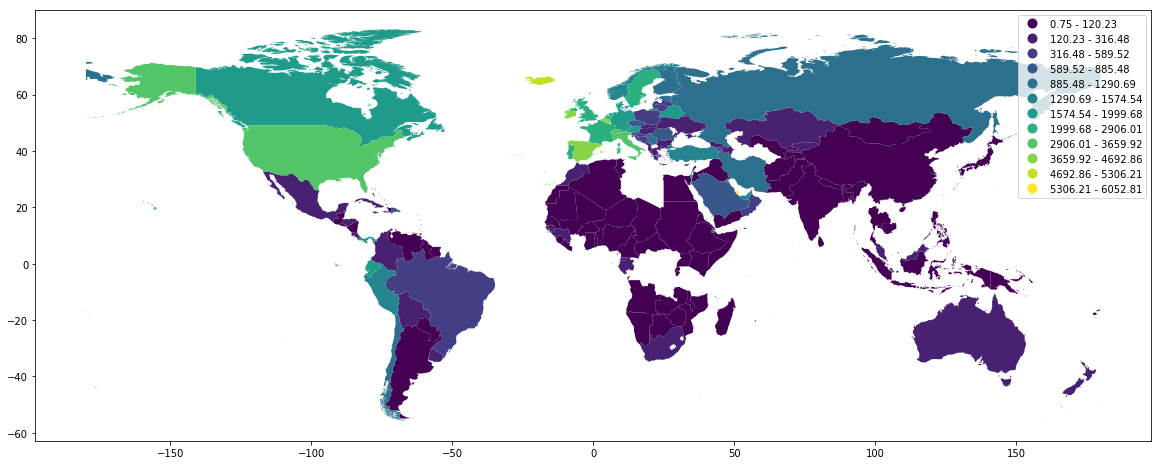

In [22]:
import matplotlib.pyplot as plt
# variable = '2020-05-05'
vmin, vmax = 0, dataPivotedWithWorld['2020-05-05'].max()
#fig, ax = plt.subplots(1, figsize=(50, 50))
ax.axis('off')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#fig.colorbar(sm)
#dataPivotedWithWorld = dataPivotedWithWorld[['country', 'geometry', '2020-05-05']]
dataPivotedWithWorld.plot(column = '2020-05-05', scheme = 'fisherjenks', figsize = (20, 20), k = 12, legend = True)
#dataPivotedWithWorld.plot(column = '2020-05-05', scheme = 'fisherjenks', ax = ax)